In [1]:
import ee
import geemap
import os
import numpy as np
from scipy import signal as sp
from matplotlib import pyplot as plt

In [2]:
Map = geemap.Map(center = (-2.609097222, -60.20929722), zoom = 10)
Map

Map(center=[-2.609097222, -60.20929722], controls=(WidgetControl(options=['position'], widget=HBox(children=(T…

In [3]:
manaus_shp = '/Users/morgansteckler/Downloads/venus_fgmanaus_footprint/venus_fgmanaus_footprint.shp'
manaus = geemap.shp_to_ee(manaus_shp)
info = manaus.geometry()
manaus = ee.Geometry(info)

In [4]:
atto_shp = '/Users/morgansteckler/Downloads/venus_atto_footprint/venus_atto_footprint.shp'
atto = geemap.shp_to_ee(atto_shp)
info = atto.geometry()
atto = ee.Geometry(info)

In [5]:
corumba_shp = '/Users/morgansteckler/Downloads/venus_corumba_footprint/venus_corumba_footprint.shp'
corumba = geemap.shp_to_ee(corumba_shp)
info = corumba.geometry()
corumba = ee.Geometry(info)

In [6]:
mato_shp = '/Users/morgansteckler/Downloads/venus_mato_footprint/venus_mato_footprint.shp'
mato = geemap.shp_to_ee(mato_shp)
info = mato.geometry()
mato = ee.Geometry(info)

In [7]:
saop_shp = '/Users/morgansteckler/Downloads/venus_saop_footprint/venus_saop_footprint.shp'
saop = geemap.shp_to_ee(saop_shp)
info = saop.geometry()
saop = ee.Geometry(info)

In [8]:
#IMPORTANT
#Select geom of interest
fc = manaus

In [9]:
#Calculate NDRE and set palette
def addNDRE(image):
    ndre = image.normalizedDifference(['B8', 'B5']).rename('NDRE')
    return image.addBands(ndre)
ndre_params = ({'min': 0.0,'max': 1.0, 'palette' : 
               ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
               '74A901', '66A000', '529400', '3E8601', '207401', '056201',
               '004C00', '023B01', '012E01', '011D01', '011301']})

#Create cloud mask
cloudBitMask = ee.Number(2).pow(10).int()
cirrusBitMask = ee.Number(2).pow(11).int()
def maskS2clouds(image):
    qa = image.select('QA60')
    # Both flags should be set to zero, indicating clear conditions.
    mask = (qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0)))
    return image.updateMask(mask)

In [10]:
#Load sentinel-2 data
s2 = (ee.ImageCollection('COPERNICUS/S2')#Select S2 1-C level data
      .select(['B5', 'B8', 'QA60']) #Select necessary bands to reduce memory usage
      .filterBounds(fc) #Narrow data spatially
      .filterDate(ee.Date('2016-01-01'), ee.Date('2019-12-31')) #Select years of interest
      .sort('CLOUDY_PIXEL_PERCENTAGE', False) #Put smallest %cloud image on top of stack
      .map(addNDRE)) #calculate NDRE and add as band

In [11]:
#Create a masked collection
masked = s2.map(maskS2clouds)

In [12]:
#15-day step
years = ee.List.sequence(2016, 2019)
step = ee.List.sequence(1, 365, 15)
col = masked

def byYear(y):
    y = ee.Number(y)
    def byStep(d):
        d = ee.Number(d)
        return (col
                .filter(ee.Filter.calendarRange(y, y.add(1), 'year'))
                .filter(ee.Filter.calendarRange(d, d.add(15), 'day_of_year'))
                .qualityMosaic('NDRE')
                .set('year', y).set('day_of_year', d))
    return step.map(byStep)

col = ee.ImageCollection.fromImages(years.map(byYear).flatten())
col = col.map(lambda image: image.clip(fc)).select('NDRE') 

In [13]:
count = col.size().getInfo()
print(count)

100


In [22]:
properties = col.aggregate_array('day_of_year').getInfo()
print(properties)

[[1, 2016], [16, 2016], [31, 2016], [46, 2016], [61, 2016], [76, 2016], [91, 2016], [106, 2016], [121, 2016], [136, 2016], [151, 2016], [166, 2016], [181, 2016], [196, 2016], [211, 2016], [226, 2016], [241, 2016], [256, 2016], [271, 2016], [286, 2016], [301, 2016], [316, 2016], [331, 2016], [346, 2016], [361, 2016], [1, 2017], [16, 2017], [31, 2017], [46, 2017], [61, 2017], [76, 2017], [91, 2017], [106, 2017], [121, 2017], [136, 2017], [151, 2017], [166, 2017], [181, 2017], [196, 2017], [211, 2017], [226, 2017], [241, 2017], [256, 2017], [271, 2017], [286, 2017], [301, 2017], [316, 2017], [331, 2017], [346, 2017], [361, 2017], [1, 2018], [16, 2018], [31, 2018], [46, 2018], [61, 2018], [76, 2018], [91, 2018], [106, 2018], [121, 2018], [136, 2018], [151, 2018], [166, 2018], [181, 2018], [196, 2018], [211, 2018], [226, 2018], [241, 2018], [256, 2018], [271, 2018], [286, 2018], [301, 2018], [316, 2018], [331, 2018], [346, 2018], [361, 2018], [1, 2019], [16, 2019], [31, 2019], [46, 2019], [

In [106]:
bands = col.first().bandNames().getInfo()
print(bands)

['NDRE']


In [24]:
geom = fc

In [12]:
# Mean
def region_mean_Image(img):
    # mean over all pixels in the region for the image
    return img.set('mean', img.reduceRegion(ee.Reducer.mean(), geometry=geom, scale=20)) 

def region_mean_ImageCollection(ic):
    # mean over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_mean_Image)
    stats_list = stats.aggregate_array('mean')
    return np.array(stats_list.getInfo())

# Median
def region_median_Image(img):
    # mean over all pixels in the region for the image
    return img.set('median', img.reduceRegion(ee.Reducer.median(), geometry=geom, scale=20)) 

def region_median_ImageCollection(ic):
    # mean over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_median_Image)
    stats_list = stats.aggregate_array('median')
    return np.array(stats_list.getInfo())

# Stddev
def region_stddev_Image(img):
    # stddev over all pixels in the region for the image
    return img.set('stddev', img.reduceRegion(ee.Reducer.stdDev(), geometry=geom, scale=20)) 

def region_stddev_ImageCollection(ic):
    # stddev over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_stddev_Image)
    stats_list = stats.aggregate_array('stddev')
    return np.array(stats_list.getInfo())

# Percentiles
def region_percentiles_Image(img):
    # 5,10,25,75,90,95 percentiles over all pixels in the region for the image
    return img.set('percentiles', img.reduceRegion(ee.Reducer.percentile([5,10,25,75,90,95]), geometry=geom, scale=20)) #) mean, median, stdDev, percentiles

def region_percentiles_ImageCollection(ic):
    # percentiles over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_percentiles_Image)
    stats_list = stats.aggregate_array('percentiles')
    return np.array(stats_list.getInfo())

In [13]:
#Create list of dictionaries as [{'NDRE': value} ...]
mean_list = region_mean_ImageCollection(col)

In [394]:
median_list = region_median_ImageCollection(col)
stddev_list = region_stddev_ImageCollection(col)
percentile_list = region_percentiles_ImageCollection(col)

In [14]:
#Show if there are any issues with data
print(mean_list)

[{'NDRE': 0.5030891494099957} {'NDRE': 0.49895764472489373}
 {'NDRE': 0.43767322374377976} {'NDRE': 0.31744898209271444}
 {'NDRE': None} {} {'NDRE': 0.43126153826594005}
 {'NDRE': 0.41254577961483685} {'NDRE': None} {'NDRE': 0.3831770814714746}
 {'NDRE': 0.38065670122363654} {'NDRE': 0.46061491421680045}
 {'NDRE': 0.5515295931288112} {'NDRE': 0.5483366225706279}
 {'NDRE': 0.4954471597594955} {'NDRE': 0.5353923234907878} {'NDRE': None}
 {'NDRE': 0.5046527771530435} {'NDRE': 0.4472456013540283}
 {'NDRE': 0.4199267305255908} {'NDRE': 0.4605207602431875}
 {'NDRE': 0.28481933009540883} {'NDRE': 0.33935017589481226}
 {'NDRE': 0.17955733776386065} {} {'NDRE': 0.21768495722639128}
 {'NDRE': 0.5032752455688525} {'NDRE': 0.48979420283550806}
 {'NDRE': 0.31039250579858807} {'NDRE': 0.3169110062770151}
 {'NDRE': 0.39680648578260386} {'NDRE': 0.4319946783462964}
 {'NDRE': 0.44428758357445186} {'NDRE': 0.3736806083710723}
 {'NDRE': 0.4516451293060638} {'NDRE': 0.5355466759258767}
 {'NDRE': 0.4840548

In [375]:
#Replace empty dicts with {'NDRE': None}
#Atto: 5, 24
#Saop: 9, 24, 99
dic = {'NDRE': None}
p_dic = {'NDRE_p10': None, 'NDRE_p25': None, 'NDRE_p5': None, 'NDRE_p75': None, 'NDRE_p90': None, 'NDRE_p95': None}
mean_list[5], mean_list[24] = dic, dic
median_list[5], median_list[24] = dic, dic
stddev_list[5], stddev_list[24] = dic, dic
percentile_list[5], percentile_list[24] = p_dic, p_dic

In [396]:
#Take only the ndre mean, med, stddev dict values and append to new list
def newList(alist):
    list_name = []
    for value in alist:
        list_name.append(value['NDRE'])
    return list_name

#Append ndre percentile dict values to new lists
def p_list(alist):
    p10, p25, p5, p75, p90, p95 = [], [], [], [], [], []
    for value in alist:
        p5.append(value['NDRE_p5'])
        p10.append(value['NDRE_p10'])
        p25.append(value['NDRE_p25'])
        p75.append(value['NDRE_p75'])
        p90.append(value['NDRE_p90'])
        p95.append(value['NDRE_p95'])
    return p5, p10, p25, p75, p90, p95

In [397]:
#Make lists for each set of values
mean_ndre = newList(mean_list)
median_ndre = newList(median_list)
stddev_ndre = newList(stddev_list)
percentile_ndre = p_list(percentile_list)

In [378]:
mean_ndre = [np.nan if v is None else v for v in mean_ndre]
median_ndre = [np.nan if v is None else v for v in median_ndre]
stddev_ndre = [np.nan if v is None else v for v in stddev_ndre]
percentile_ndre = [np.nan if v is None else v for v in percentile_ndre]

In [398]:
#Make lists with +/- SD
plus_error = [x + y for x,y in zip(mean_ndre, stddev_ndre)]
minus_error = [x - y for x,y in zip(mean_ndre, stddev_ndre)]

In [399]:
#Create 15-step list for four years
period = list(range(0,100))
period = np.array(period)

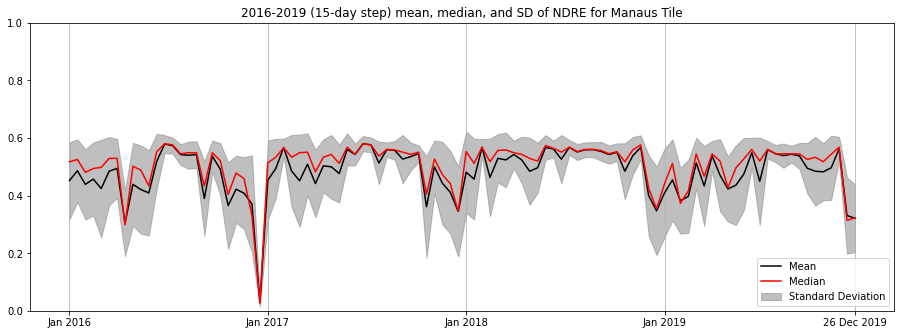

In [400]:
#Manaus Flux Site
#Mean and SD
x = period
y = mean_ndre
m = median_ndre
plt.axes([2, 0, 2, 1])
plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
plt.title('2016-2019 (15-day step) mean, median, and SD of NDRE for Manaus Tile')
plt.fill_between(x, plus_error, minus_error, color = "grey", alpha = .5, label = "Standard Deviation")
mean = plt.plot(x,y, color = "black", label = "Mean")
median = plt.plot(x,m, color = "red", label = "Median")
plt.legend(loc = "lower right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()

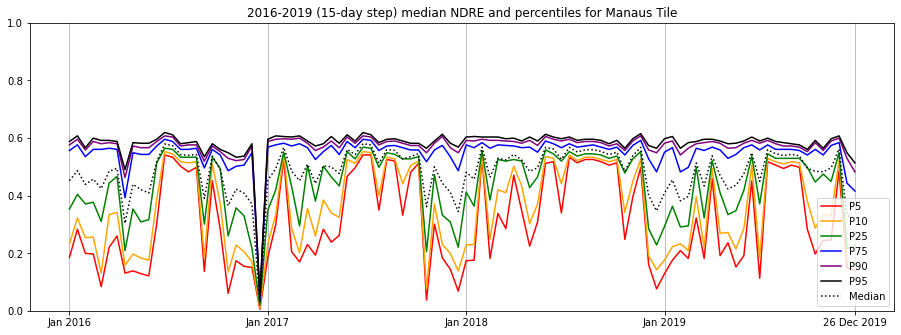

In [401]:
#Manaus Flux Site
#Median and Percentiles
x = period
plt.axes([2, 0, 2, 1])
plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
y5 = plt.plot(x,percentile_ndre[0], color = "red", label = "P5")
y10 = plt.plot(x,percentile_ndre[1], color = "orange", label = "P10")
y25 = plt.plot(x,percentile_ndre[2], color = "green", label = "P25")
y75 = plt.plot(x,percentile_ndre[3], color = "blue", label = "P75")
y90 = plt.plot(x,percentile_ndre[4], color = "purple", label = "P90")
y95 = plt.plot(x,percentile_ndre[5], color = "black", label = "P95")
plt.title('2016-2019 (15-day step) median NDRE and percentiles for Manaus Tile')
median = plt.plot(x,y, color = "black", linestyle = ":", label = "Median")
plt.legend(loc = "lower right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()

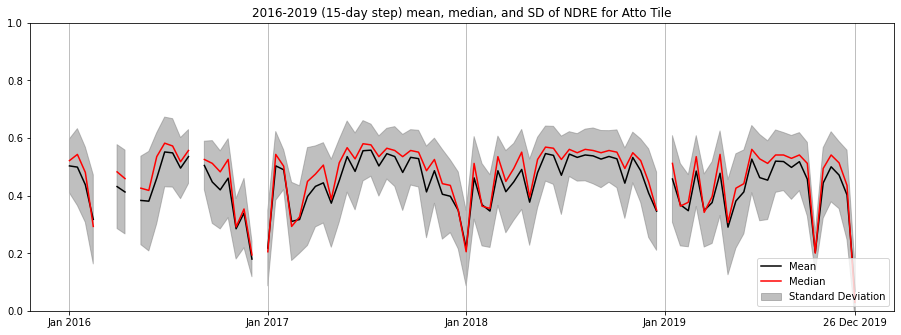

In [381]:
#Atto Flux Site
#Mean and SD
x = period
y = mean_ndre
m = median_ndre
plt.axes([2, 0, 2, 1])
plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
plt.title('2016-2019 (15-day step) mean, median, and SD of NDRE for Atto Tile')
plt.fill_between(x, plus_error, minus_error, color = "grey", alpha = .5, label = "Standard Deviation")
mean = plt.plot(x,y, color = "black", label = "Mean")
median = plt.plot(x,m, color = "red", label = "Median")
plt.legend(loc = "lower right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()

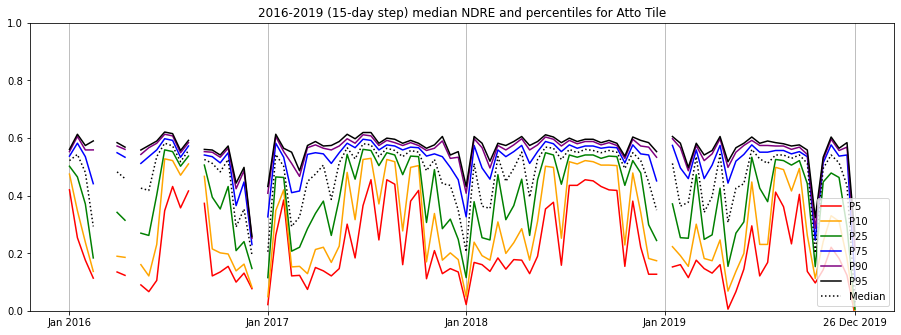

In [382]:
#Atto Flux Site
#Median and Percentiles
x = period
plt.axes([2, 0, 2, 1])
plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
y5 = plt.plot(x,percentile_ndre[0], color = "red", label = "P5")
y10 = plt.plot(x,percentile_ndre[1], color = "orange", label = "P10")
y25 = plt.plot(x,percentile_ndre[2], color = "green", label = "P25")
y75 = plt.plot(x,percentile_ndre[3], color = "blue", label = "P75")
y90 = plt.plot(x,percentile_ndre[4], color = "purple", label = "P90")
y95 = plt.plot(x,percentile_ndre[5], color = "black", label = "P95")
plt.title('2016-2019 (15-day step) median NDRE and percentiles for Atto Tile')
median = plt.plot(x,m, color = "black", linestyle = ":", label = "Median")
plt.legend(loc = "lower right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()

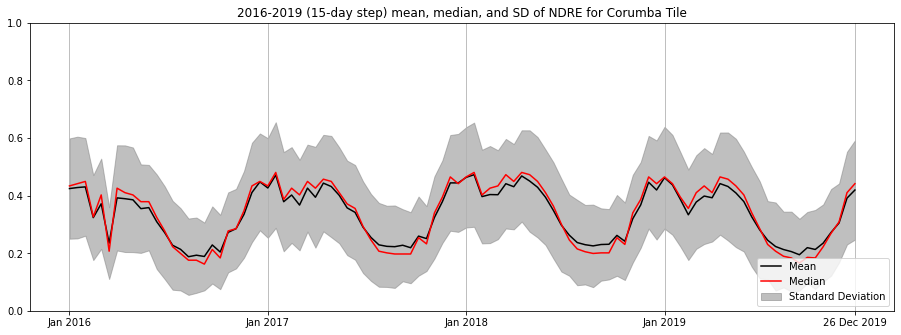

In [356]:
#Corumba Flux Site
#Mean and SD
x = period
y = mean_ndre
m = median_ndre
plt.axes([2, 0, 2, 1])
plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
plt.title('2016-2019 (15-day step) mean, median, and SD of NDRE for Corumba Tile')
plt.fill_between(x, plus_error, minus_error, color = "grey", alpha = .5, label = "Standard Deviation")
mean = plt.plot(x,y, color = "black", label = "Mean")
median = plt.plot(x,m, color = "red", label = "Median")
plt.legend(loc = "lower right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()

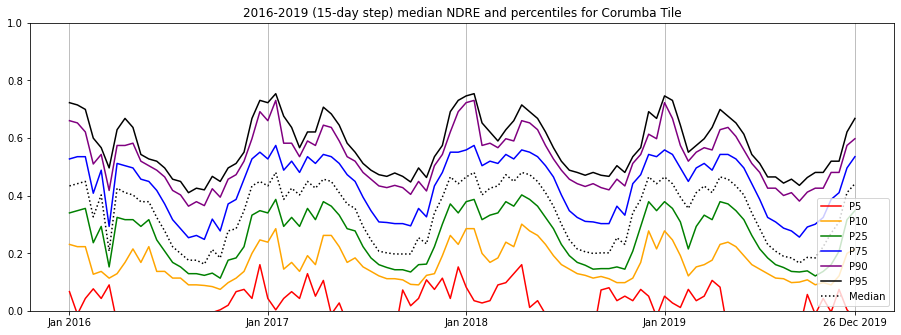

In [361]:
#Corumba Flux Site
#Median and Percentiles
x = period
plt.axes([2, 0, 2, 1])
plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
y5 = plt.plot(x,percentile_ndre[0], color = "red", label = "P5")
y10 = plt.plot(x,percentile_ndre[1], color = "orange", label = "P10")
y25 = plt.plot(x,percentile_ndre[2], color = "green", label = "P25")
y75 = plt.plot(x,percentile_ndre[3], color = "blue", label = "P75")
y90 = plt.plot(x,percentile_ndre[4], color = "purple", label = "P90")
y95 = plt.plot(x,percentile_ndre[5], color = "black", label = "P95")
plt.title('2016-2019 (15-day step) median NDRE and percentiles for Corumba Tile')
median = plt.plot(x,m, color = "black", linestyle = ":", label = "Median")
plt.legend(loc = "lower right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()

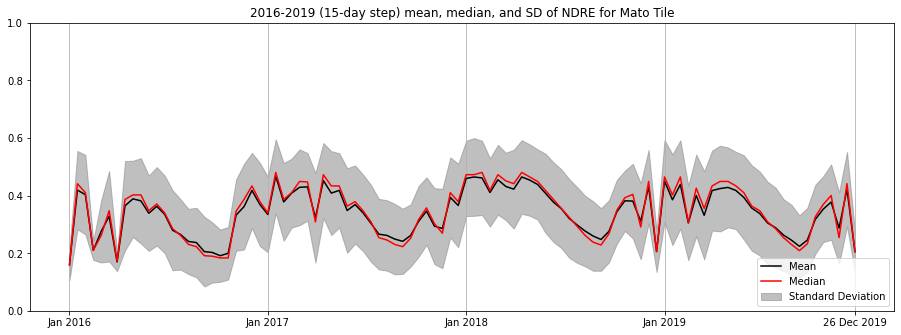

In [338]:
#Mato Flux Site
#Mean and SD
x = period
y = mean_ndre
m = median_ndre
plt.axes([2, 0, 2, 1])
plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
plt.title('2016-2019 (15-day step) mean, median, and SD of NDRE for Mato Tile')
plt.fill_between(x, plus_error, minus_error, color = "grey", alpha = .5, label = "Standard Deviation")
mean = plt.plot(x,y, color = "black", label = "Mean")
median = plt.plot(x,m, color = "red", label = "Median")
plt.legend(loc = "lower right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()

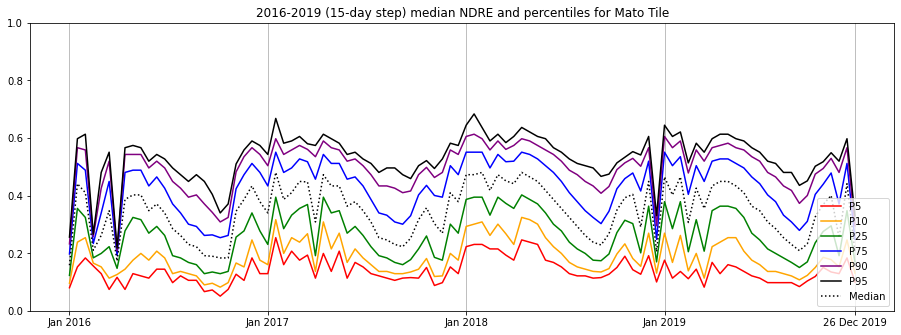

In [337]:
#Mato Flux Site
#Median and Percentiles
x = period
plt.axes([2, 0, 2, 1])
plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
y5 = plt.plot(x,percentile_ndre[0], color = "red", label = "P5")
y10 = plt.plot(x,percentile_ndre[1], color = "orange", label = "P10")
y25 = plt.plot(x,percentile_ndre[2], color = "green", label = "P25")
y75 = plt.plot(x,percentile_ndre[3], color = "blue", label = "P75")
y90 = plt.plot(x,percentile_ndre[4], color = "purple", label = "P90")
y95 = plt.plot(x,percentile_ndre[5], color = "black", label = "P95")
plt.title('2016-2019 (15-day step) median NDRE and percentiles for Mato Tile')
median = plt.plot(x,m, color = "black", linestyle = ":", label = "Median")
plt.legend(loc = "lower right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()

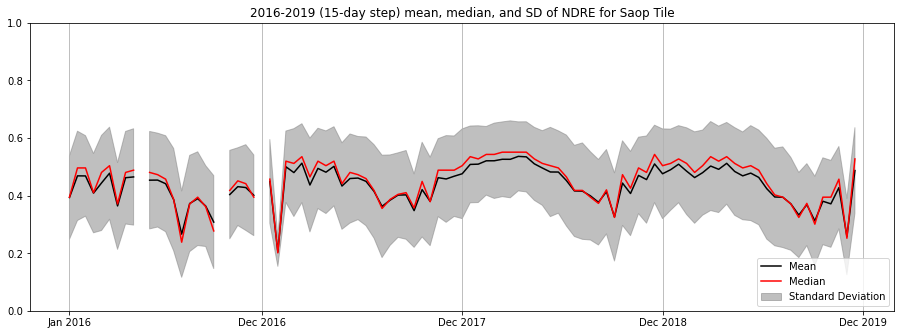

In [314]:
#Saop Flux Site
#Mean and SD
x = period
y = mean_ndre
m = median_ndre
plt.axes([2, 0, 2, 1])
plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
plt.title('2016-2019 (15-day step) mean, median, and SD of NDRE for Saop Tile')
plt.fill_between(x, plus_error, minus_error, color = "grey", alpha = .5, label = "Standard Deviation")
mean = plt.plot(x,y, color = "black", label = "Mean")
median = plt.plot(x,m, color = "red", label = "Median")
plt.legend(loc = "lower right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()

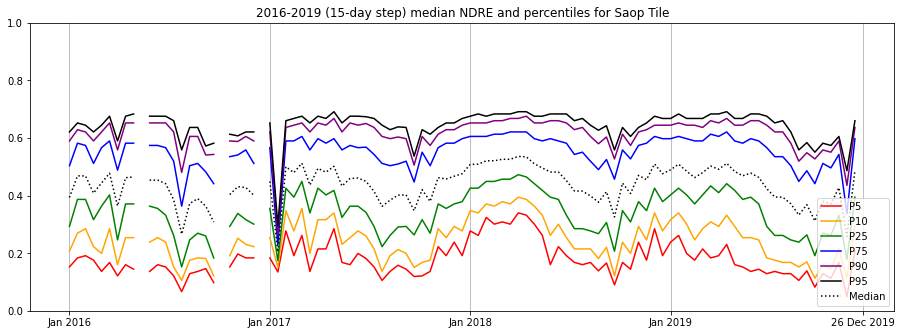

In [315]:
#Saop Flux Site
#Median and Percentiles
x = period
plt.axes([2, 0, 2, 1])
plt.ylim(bottom = 0, top = 1)
plt.grid(b = True, which = 'major', axis = 'x')
y5 = plt.plot(x,percentile_ndre[0], color = "red", label = "P5")
y10 = plt.plot(x,percentile_ndre[1], color = "orange", label = "P10")
y25 = plt.plot(x,percentile_ndre[2], color = "green", label = "P25")
y75 = plt.plot(x,percentile_ndre[3], color = "blue", label = "P75")
y90 = plt.plot(x,percentile_ndre[4], color = "purple", label = "P90")
y95 = plt.plot(x,percentile_ndre[5], color = "black", label = "P95")
plt.title('2016-2019 (15-day step) median NDRE and percentiles for Saop Tile')
median = plt.plot(x,m, color = "black", linestyle = ":", label = "Median")
plt.legend(loc = "lower right")
plt.xticks(ticks = [0, 25, 50, 75, 99], labels = ['Jan 2016', 'Jan 2017', 'Jan 2018', 'Jan 2019', '26 Dec 2019'])
plt.show()

In [ ]:
#Export images from a collection
out_dir = '6ru@theseus:~/Manaus/'
geemap.ee_export_image_collection(col, out_dir, region = manaus, scale = 20, file_per_band=False)

Total number of images: 100

Exporting 1/100: 0.tif
Generating URL ...
Please wait ...
